In [1]:
# Install Keras Tuner
!pip install keras-tuner

# Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import numpy as np
from nltk.corpus import gutenberg
import nltk
nltk.download('gutenberg')
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
# Load raw text from Hamlet and convert to lowercase
text = gutenberg.raw('shakespeare-hamlet.txt').lower()

# Remove editorial notes
text = re.sub(r'\[.*?]', '', text)

# Normalize whitespace
text = re.sub(r'\s+', ' ', text)

# Preserve relevant punctuation (. ! ?)
text = re.sub(r'[^\w\s.!?]', '', text)

# Split into sentences
sentences = re.split(r'(?<=[.!?])\s+', text)

# Filter out short sentences
sentences = [s.strip() for s in sentences if len(s.strip()) > 5]

print(f"Text size (characters): {len(text)}")
print(f"Number of sentences: {len(sentences)}")



Text size (characters): 154219
Number of sentences: 2053


In [3]:
# Tokenize the sentences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
total_words = min(10000, len(tokenizer.word_index) + 1)

print(f"Total words in vocabulary: {total_words}")


Total words in vocabulary: 4794


In [4]:
# Function to create dataset with a sliding window
def create_dataset(sentences, window_size, batch_size):
    sequences = tokenizer.texts_to_sequences(sentences)
    flat_sequences = [item for sublist in sequences for item in sublist]

    inputs = []
    outputs = []
    for i in range(len(flat_sequences) - window_size):
        inputs.append(flat_sequences[i:i+window_size])
        outputs.append(flat_sequences[i+window_size])

    dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
    dataset = dataset.shuffle(10000).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset, inputs, outputs

window_size = 15
batch_size = 128
dataset, inputs, outputs = create_dataset(sentences, window_size, batch_size)

# Calculate steps per epoch
steps_per_epoch = len(inputs) // batch_size


In [5]:
# Generate train/test arrays
x, y = [], []
for seq in tokenizer.texts_to_sequences(sentences):
    for i in range(len(seq) - window_size):
        x.append(seq[i:i+window_size])
        y.append(seq[i+window_size])
x, y = np.array(x), np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Shape of x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}, y_test: {y_test.shape}")


Shape of x_train: (8772, 15), y_train: (8772,)
Shape of x_test: (2194, 15), y_test: (2194,)


In [6]:
def model_builder(hp):
    model = Sequential()
    model.add(Embedding(input_dim=total_words, output_dim=hp.Choice('embedding_dim', [64, 128, 160]), input_length=window_size))
    model.add(Bidirectional(LSTM(units=hp.Choice('units1', [64, 128]), return_sequences=False)))
    model.add(Dropout(rate=hp.Choice('dropout', [0.2, 0.3, 0.4])))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.01, 0.001])),
                  metrics=['accuracy'])
    return model


In [7]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='next_word_prediction'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test),
             callbacks=[early_stopping, lr_scheduler], verbose=1)


Reloading Tuner from kt_dir/next_word_prediction/tuner0.json


In [8]:
# Get best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
for param in best_hps.values:
    print(f"{param}: {best_hps[param]}")

# Train the best model using the tf.data dataset
history = best_model.fit(
    dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate on test set
loss, acc = best_model.evaluate(x_test, y_test)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {acc:.4f}")

# Clean memory
tf.keras.backend.clear_session()
gc.collect()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best hyperparameters found:
embedding_dim: 160
units1: 64
dropout: 0.3
learning_rate: 0.01
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


228/228 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.0579 - loss: 6.4514 - val_accuracy: 0.0834 - val_loss: 6.1886 - learning_rate: 0.0100
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0843 - loss: 5.8148 - val_accuracy: 0.1263 - val_loss: 5.4131 - learning_rate: 0.0100
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1098 - loss: 5.2663 - val_accuracy: 0.2142 - val_loss: 4.4450 - learning_rate: 0.0100
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1590 - loss: 4.6459 - val_accuracy: 0.3396 - val_loss: 3.4921 - learning_rate: 0.0100
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2157 - loss: 4.0645 - val_accuracy: 0.4704 - val_loss: 2.7756 - learning_rate: 0.0100
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2858 - loss: 3.5475 - val_accuracy: 0.5469 - val_loss: 2.2204 - learning_rate: 0.0100
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3534 - loss: 3.0932 - v

0

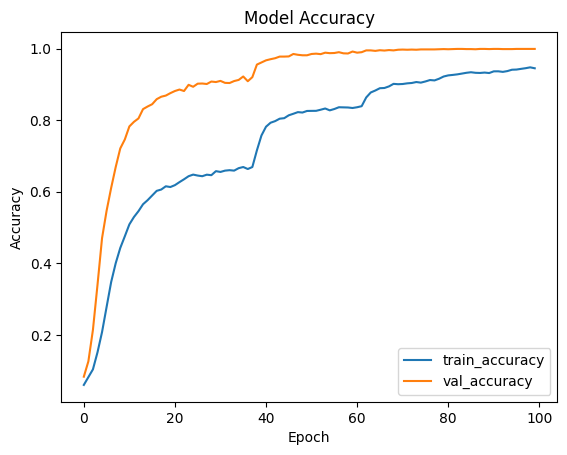

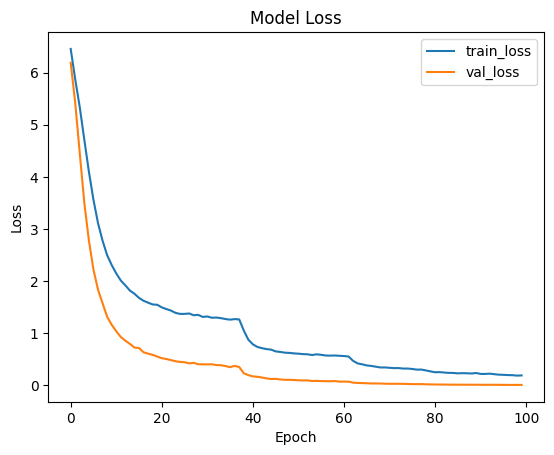

In [9]:
# Visualize Training Results
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
# Generate Text for Qualitative Evaluation
def predict_next_word(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=window_size, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=1)[0]
    return tokenizer.index_word.get(predicted_word_index, "<OOV>")

# Test text generation
seed_text = "to be or not to be"
print("Next word prediction:", predict_next_word(best_model, tokenizer, seed_text))

Next word prediction: the


In [16]:
def generate_text_sequence(model, tokenizer, seed_text, num_words=10):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=window_size, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted, axis=1)[0]
        output_word = tokenizer.index_word.get(predicted_index, "<OOV>")
        seed_text += " " + output_word
    return seed_text

    seed_text = "to be or not to be"
print("Sentence prediction:", generate_text_sequence(best_model, tokenizer, seed_text))

Sentence prediction: to be or not to be a father for loue the is the king marke his father lost his was


In [ ]:
## Save the model
best_model.save("next_word_lstm.h5")
## Save the tokenizer
import pickle
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)